In [19]:
from copy import deepcopy
from IPython import display

import gym
import numpy as np
from gym.spaces import Discrete, Dict, Box
import matplotlib.pyplot as plt


In [104]:
import math
import gym
from gym import spaces, logger
from gym.utils import seeding
import numpy as np


class CartPoleEnv(gym.Env):

    metadata = {
        'render.modes': ['human', 'rgb_array'],
        'video.frames_per_second': 50
    }

    def __init__(self):
        self.gravity = 9.8
        self.masscart = 1.0
        self.masspole = 0.1
        self.total_mass = (self.masspole + self.masscart)
        self.length = 0.5  # actually half the pole's length
        self.polemass_length = (self.masspole * self.length)
        self.force_mag = 10.0
        self.tau = 0.02  # seconds between state updates
        self.kinematics_integrator = 'euler'

        # Angle at which to fail the episode
        self.theta_threshold_radians = 12 * 2 * math.pi / 360
        self.x_threshold = 2.4

        # Angle limit set to 2 * theta_threshold_radians so failing observation
        # is still within bounds.
        high = np.array([self.x_threshold * 2,
                         np.finfo(np.float32).max,
                         self.theta_threshold_radians * 2,
                         np.finfo(np.float32).max],
                        dtype=np.float32)

        self.action_space = spaces.Box(low=np.array([-1.0]), high=np.array([1.0]), dtype=np.float32)
        self.observation_space = spaces.Box(-high, high, dtype=np.float32)

        self.seed()
        self.viewer = None
        self.state = None

        self.steps_beyond_done = None

    def seed(self, seed=None):
        self.np_random, seed = seeding.np_random(seed)
        return [seed]

    def step(self, action):
        err_msg = "%r (%s) invalid" % (action, type(action))
        assert self.action_space.contains(action), err_msg

        x, x_dot, theta, theta_dot = self.state
        force = action[0] # self.force_mag if action == 1 else -self.force_mag
        costheta = math.cos(theta)
        sintheta = math.sin(theta)
        
        # For the interested reader:
        # https://coneural.org/florian/papers/05_cart_pole.pdf
        temp = (force + self.polemass_length * theta_dot ** 2 * sintheta) / self.total_mass
        thetaacc = (self.gravity * sintheta - costheta * temp) / (self.length * (4.0 / 3.0 - self.masspole * costheta ** 2 / self.total_mass))
        xacc = temp - self.polemass_length * thetaacc * costheta / self.total_mass

        if self.kinematics_integrator == 'euler':
            x = x + self.tau * x_dot
            x_dot = x_dot + self.tau * xacc
            theta = theta + self.tau * theta_dot
            theta_dot = theta_dot + self.tau * thetaacc
        else:  # semi-implicit euler
            x_dot = x_dot + self.tau * xacc
            x = x + self.tau * x_dot
            theta_dot = theta_dot + self.tau * thetaacc
            theta = theta + self.tau * theta_dot
            


        self.state = (x, x_dot, theta, theta_dot)

        done = bool(
            x < -self.x_threshold
            or x > self.x_threshold
            or theta < -self.theta_threshold_radians
            or theta > self.theta_threshold_radians
        )

        if not done:
            reward = 1.0
        elif self.steps_beyond_done is None:
            # Pole just fell!
            self.steps_beyond_done = 0
            reward = 1.0
        else:
            if self.steps_beyond_done == 0:
                logger.warn(
                    "You are calling 'step()' even though this "
                    "environment has already returned done = True. You "
                    "should always call 'reset()' once you receive 'done = "
                    "True' -- any further steps are undefined behavior."
                )
            self.steps_beyond_done += 1
            reward = 0.0

        return np.array(self.state), reward, done, {}

    def reset(self):
        self.state = self.np_random.uniform(low=-0.05, high=0.05, size=(4,))
        self.steps_beyond_done = None
        return np.array(self.state)

    def render(self, mode='human'):
        screen_width = 600
        screen_height = 400

        world_width = self.x_threshold * 2
        scale = screen_width/world_width
        carty = 100  # TOP OF CART
        polewidth = 10.0
        polelen = scale * (2 * self.length)
        cartwidth = 50.0
        cartheight = 30.0

        if self.viewer is None:
            from gym.envs.classic_control import rendering
            self.viewer = rendering.Viewer(screen_width, screen_height)
            l, r, t, b = -cartwidth / 2, cartwidth / 2, cartheight / 2, -cartheight / 2
            axleoffset = cartheight / 4.0
            cart = rendering.FilledPolygon([(l, b), (l, t), (r, t), (r, b)])
            self.carttrans = rendering.Transform()
            cart.add_attr(self.carttrans)
            self.viewer.add_geom(cart)
            l, r, t, b = -polewidth / 2, polewidth / 2, polelen - polewidth / 2, -polewidth / 2
            pole = rendering.FilledPolygon([(l, b), (l, t), (r, t), (r, b)])
            pole.set_color(.8, .6, .4)
            self.poletrans = rendering.Transform(translation=(0, axleoffset))
            pole.add_attr(self.poletrans)
            pole.add_attr(self.carttrans)
            self.viewer.add_geom(pole)
            self.axle = rendering.make_circle(polewidth/2)
            self.axle.add_attr(self.poletrans)
            self.axle.add_attr(self.carttrans)
            self.axle.set_color(.5, .5, .8)
            self.viewer.add_geom(self.axle)
            self.track = rendering.Line((0, carty), (screen_width, carty))
            self.track.set_color(0, 0, 0)
            self.viewer.add_geom(self.track)

            self._pole_geom = pole

        if self.state is None:
            return None

        # Edit the pole polygon vertex
        pole = self._pole_geom
        l, r, t, b = -polewidth / 2, polewidth / 2, polelen - polewidth / 2, -polewidth / 2
        pole.v = [(l, b), (l, t), (r, t), (r, b)]

        x = self.state
        cartx = x[0] * scale + screen_width / 2.0  # MIDDLE OF CART
        self.carttrans.set_translation(cartx, carty)
        self.poletrans.set_rotation(-x[2])

        return self.viewer.render(return_rgb_array=mode == 'rgb_array')

    def set_states(self, state):
        self.states = state
    def close(self):
        if self.viewer:
            self.viewer.close()
            self.viewer = None

In [131]:
env = CartPoleEnv()

In [132]:
env.reset()

array([-0.01565086, -0.00901421,  0.03234323, -0.02481927])

In [133]:
env.set_states([0.0, 0.0, -0.2, 0.0])

In [135]:
env.states

[0.0, 0.0, -0.2, 0.0]

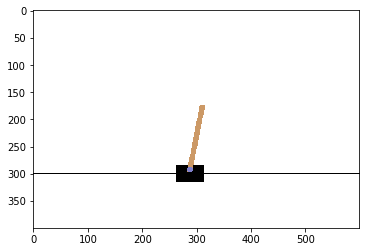

In [134]:
for i in range(25):
    plt.imshow(env.render(mode='rgb_array'))
    display.display(plt.gcf())  
    display.clear_output(wait=True)
    obs, rew, done, _ = env.step(np.array([-1]))
    obss.append(obs)
    if done:
        break
env.close()